In [34]:
import torch
import torchvision
import torchvision.transforms as transforms

# transforms.Compose : 이미지에 적용할 여러 변환을 묶는 역할
    # transforms.ToTensor() : 이미지를 텐서로 변환 -> 픽셀 값을 0-255 -> 0-1 사이로 정규화
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) : 각 색상 채널(빨강, 초록, 파랑)의 픽셀 값 범위를 -1 ~ 1 사이로 정규화

transfrom = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256 # 전체(목표) 배치 크기
sub_batch_size = 32 # 부분 배치 크기

# 데이터셋 다운로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transfrom)

# 데이터셋 불러오기
# DataLoader : 데이터셋을 배치 단위로 관리하는 역할
    # batch_size : 배치 크기
    # shuffle : 데이터를 섞을지 여부
    # num_workers : 데이터 로드에 사용할 쓰레드 수
train_loader = torch.utils.data.DataLoader(trainset, batch_size=sub_batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

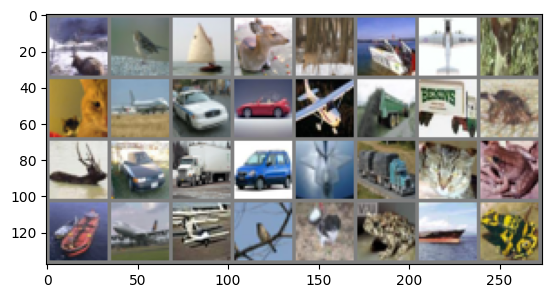

 deer  bird  ship  deer  deer  ship plane  deer   cat plane   car   car plane truck truck   cat  deer   car truck   car plane truck   cat  frog  ship plane plane  bird   dog  frog  ship  frog


In [35]:
# 데이터 확인
import matplotlib.pyplot as plt
import numpy as np

# 이미지 시각화 함수
def imshow(img):
    img = img / 2 + 0.5 # 정규화된 이미지를 0-1 사이로 변환
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 하나의 batch 데이터 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)


# torchvision.utils.make_grid : 여러 이미지를 하나의 그림으로 결합
imshow(torchvision.utils.make_grid(images))

# 레이블 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(sub_batch_size)))

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return out

In [ ]:
# 32 layer plain net
class PlainNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PlainNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # _make_layer 함수 호출하여 여러 개의 블록 그룹 생성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # average pooling 레이어 사용
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 완전 연결 레이어(Fully Connected Layer) 512 -> 10개의 클래스로 분류
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫 번째 블록은 stride, 나머지는 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)  # 텐서를 평탄화 (배치 크기, 512)
        out = self.fc(out)
        return out
    
# 모델 생성
planet = PlainNet(BasicBlock, [3, 4, 6, 3])

In [38]:
import torch.optim as optim

# 크로스 엔트로피 손실 함수 사용
criterion = nn.CrossEntropyLoss()
# 학습률 0.0001, 모멘텀 0.9
optimizer = optim.SGD(planet.parameters(), lr=0.0001, momentum=0.9)

In [39]:
# 여러 에포크 학습
num_epochs = 3
plain_net_loss = []
plain_net_error = []  # 오류율 기록용

for epoch in range(num_epochs):
    running_loss = 0.0
    accumulated_steps = batch_size // sub_batch_size # 누적 배치 크기
    
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # 순전파 + 역전파 + 최적화
        outputs = planet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # 배치 손실 합계 계산
        running_loss += loss.item()

        # 8번마다 파라미터 업데이트(256/32 = 8) -> gradient 누적
        if (i + 1) % accumulated_steps == 0:
            optimizer.step() # 파라미터 업데이트
            optimizer.zero_grad() # 변화도(gradient) 초기화
            
            # 매번 손실 기록 (8번의 배치 평균)
            avg_loss = running_loss / accumulated_steps
            plain_net_loss.append(avg_loss)
            
            # 오류율 계산 (마지막 배치의 예측 정확도)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            error_rate = (1 - correct / total) * 100  # 오류율 (%)
            plain_net_error.append(error_rate)
            
            print(f"Step {i // accumulated_steps + 1}: Loss = {avg_loss:.4f}, Error = {error_rate:.2f}%")
            
            # running_loss 초기화 (다음 8번의 배치를 위해)
            running_loss = 0.0
    # 헉습 루프가 끝난 후, 남은 그래디언트 처리
    if (len(train_loader) % accumulated_steps) != 0:
        optimizer.step()
        optimizer.zero_grad()


Epoch 1/3
Step 1: Loss = 2.2939, Error = 81.25%
Step 2: Loss = 2.2961, Error = 87.50%
Step 3: Loss = 2.2790, Error = 90.62%
Step 4: Loss = 2.2894, Error = 84.38%
Step 5: Loss = 2.2565, Error = 81.25%
Step 6: Loss = 2.2427, Error = 87.50%
Step 7: Loss = 2.2265, Error = 81.25%
Step 8: Loss = 2.2190, Error = 93.75%
Step 9: Loss = 2.2468, Error = 84.38%
Step 10: Loss = 2.2443, Error = 87.50%
Step 11: Loss = 2.2022, Error = 87.50%
Step 12: Loss = 2.1744, Error = 75.00%
Step 13: Loss = 2.2312, Error = 87.50%
Step 14: Loss = 2.1841, Error = 81.25%
Step 15: Loss = 2.2015, Error = 87.50%
Step 16: Loss = 2.1888, Error = 81.25%
Step 17: Loss = 2.1390, Error = 84.38%
Step 18: Loss = 2.1811, Error = 81.25%
Step 19: Loss = 2.1081, Error = 84.38%
Step 20: Loss = 2.1430, Error = 78.12%
Step 21: Loss = 2.1202, Error = 87.50%
Step 22: Loss = 2.1319, Error = 71.88%
Step 23: Loss = 2.1030, Error = 81.25%
Step 24: Loss = 2.0465, Error = 81.25%
Step 25: Loss = 2.0909, Error = 75.00%
Step 26: Loss = 2.0487,

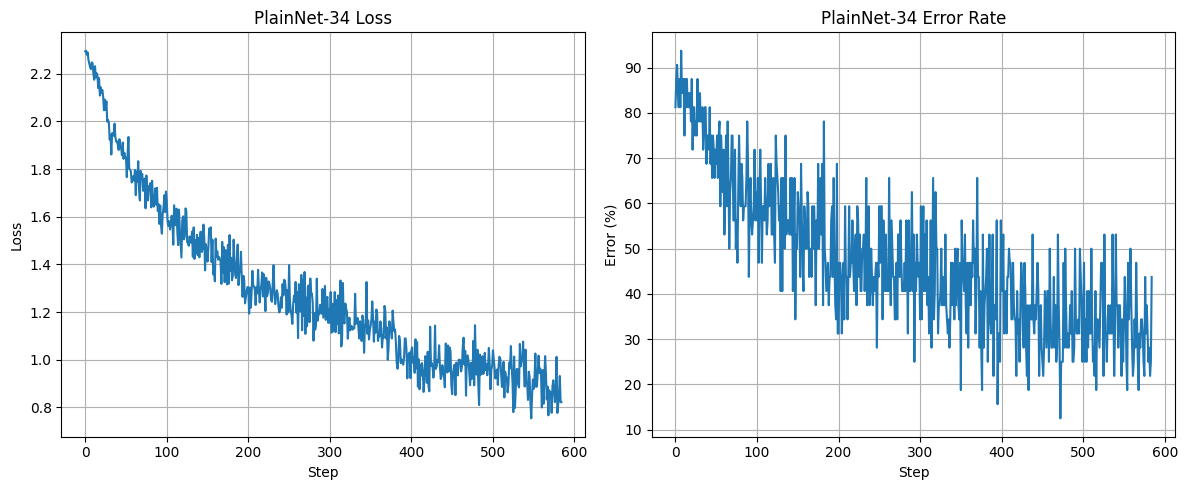

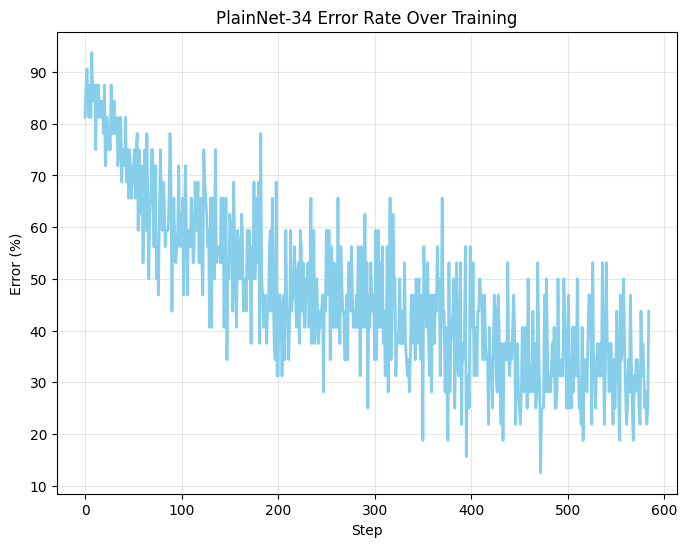

In [41]:
# 손실 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(plain_net_loss)
plt.title("PlainNet-34 Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)

# 오류율 그래프 (원하는 그래프)
plt.subplot(1, 2, 2)
plt.plot(plain_net_error)
plt.title("PlainNet-34 Error Rate")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

# 오류율만 따로 그리기
plt.figure(figsize=(8, 6))
plt.plot(plain_net_error, color='skyblue', linewidth=2)
plt.title("PlainNet-34 Error Rate Over Training")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.grid(True, alpha=0.3)
plt.show()